<a href="https://colab.research.google.com/github/fauj1x/tomato_classification/blob/main/Tomat_cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from os import mkdir
mkdir('/content/drive/MyDrive/tomat_cls')

In [ ]:
cd /content/drive/MyDrive/tomat_cls

/content/drive/MyDrive/tomat_cls


In [ ]:
!pip install --upgrade pip
!pip install roboflow ultralytics scikit-learn pandas opencv-python-headless tqdm pyyaml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 86.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 145.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.5 MB/s  0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [ultralytics]


In [ ]:
# CELL 2: download dataset dari Roboflow
import os
from roboflow import Roboflow

# --- ganti atau pakai API key yang sudah ada ---
RF_API_KEY = ""

rf = Roboflow(api_key=RF_API_KEY)
project = rf.workspace("labeling-ildly").project("tomat_anj-7iern")
version = project.version(1)

# Download in 'folder' format. This will create a folder in current working dir.
print("[INFO] Downloading dataset from Roboflow (may take a while)...")
dataset = version.download("folder")
print("[INFO] Roboflow download finished.")

# Try to auto-detect the dataset folder created by Roboflow:
cwd = os.getcwd()
candidates = []
for d in os.listdir(cwd):
    p = os.path.join(cwd, d)
    if os.path.isdir(p):
        # detection heuristic: folder contains 'train' or 'valid' subfolder
        sub = set(os.listdir(p))
        if 'train' in sub or 'valid' in sub or 'test' in sub:
            candidates.append(p)

if len(candidates) == 0:
    print("[WARN] Auto-detect failed: please set `DATA_ROOT` manually to your downloaded folder.")
    DATA_ROOT = None
else:
    # choose the most recently modified candidate
    DATA_ROOT = max(candidates, key=os.path.getmtime)
    print(f"[INFO] Dataset root auto-detected: {DATA_ROOT}")

# If auto-detect failed, you can manually set:
# DATA_ROOT = "/path/to/your/downloaded/folder"


loading Roboflow workspace...
loading Roboflow project...
[INFO] Downloading dataset from Roboflow (may take a while)...



Extracting Dataset Version Zip to tomat_anj-1 in folder:: 100%|██████████| 1316/1316 [00:16<00:00, 80.76it/s] 

[INFO] Roboflow download finished.
[INFO] Dataset root auto-detected: /content/drive/MyDrive/tomat_cls/tomat_anj-1


In [ ]:
# CELL 3: prepare structure + create data.yaml
import os
import shutil
import random
from pathlib import Path
import yaml

RNG = random.Random(42)

def is_folder_structure_ready(root):
    """
    Checks whether `root` already contains train/val/test with class subfolders.
    """
    if root is None:
        return False
    root = Path(root)
    required = ['train', 'val']  # test optional
    ctr = 0
    for r in required:
        if (root / r).exists() and any((root / r).iterdir()):
            ctr += 1
    return ctr >= 1  # accept if at least train exists (roboflow may have train/valid)

def prepare_split_from_class_folders(src_root, dst_root, classes, split=(0.8,0.1,0.1)):
    """
    src_root contains per-class folders (e.g. output_segar/, output_busuk/)
    Creates dst_root/train, dst_root/val, dst_root/test with class subfolders and copies images.
    """
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    for subset in ['train','val','test']:
        (dst_root / subset).mkdir(parents=True, exist_ok=True)

    for cls in classes:
        src_cls = src_root / cls
        if not src_cls.exists():
            raise FileNotFoundError(f"{src_cls} not found")
        imgs = [f for f in os.listdir(src_cls) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        RNG.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * split[0])
        n_val = int(n * split[1])
        for i,fn in enumerate(imgs):
            if i < n_train:
                subset = 'train'
            elif i < n_train + n_val:
                subset = 'val'
            else:
                subset = 'test'
            dst = dst_root / subset / cls
            dst.mkdir(parents=True, exist_ok=True)
            shutil.copy2(src_cls / fn, dst / fn)
    return dst_root

def write_data_yaml(root_path, names, out_yaml):
    d = {
        'train': str(Path(root_path) / 'train'),
        'val': str(Path(root_path) / 'val'),
        'test': str(Path(root_path) / 'test'),
        'nc': len(names),
        'names': names
    }
    with open(out_yaml, 'w') as f:
        yaml.dump(d, f, default_flow_style=False)
    print(f"[INFO] data.yaml written to {out_yaml}")

# Decide source for training:
# If Roboflow exported folder structure already (train/val present) -> use it directly.
# Else, if Roboflow exported single folder with classes inside, we'll split.

if DATA_ROOT is None:
    raise SystemExit("[ERR] DATA_ROOT not detected. Set DATA_ROOT manually and re-run this cell.")

if is_folder_structure_ready(DATA_ROOT):
    print("[INFO] Dataset already has train/val structure. Using downloaded dataset as-is.")
    prepared_root = DATA_ROOT
else:
    # assume DATA_ROOT contains class folders; detect classes
    classes = [d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT,d))]
    print(f"[INFO] Detected class folders: {classes}")
    prepared_root = os.path.abspath("dataset_prepared")
    if os.path.exists(prepared_root):
        print(f"[INFO] Removing existing prepared folder at {prepared_root} (to avoid duplicates).")
        shutil.rmtree(prepared_root)
    prepare_split_from_class_folders(DATA_ROOT, prepared_root, classes, split=(0.8,0.1,0.1))
    print(f"[INFO] Prepared dataset at {prepared_root}")

# Create data.yaml inside the run folder
RUNS_DIR = "runs_classify"
EXP_NAME = "rf_tomat_exp1"
os.makedirs(os.path.join(RUNS_DIR, EXP_NAME), exist_ok=True)

# Determine names automatically from prepared_root/train subfolders
train_dir = Path(prepared_root) / "train"
names = sorted([p.name for p in train_dir.iterdir() if p.is_dir()])
yaml_path = os.path.join(RUNS_DIR, EXP_NAME, "data.yaml")
write_data_yaml(prepared_root, names, yaml_path)
print("[OK] data.yaml created. Classes =", names)


[INFO] Dataset already has train/val structure. Using downloaded dataset as-is.
[INFO] data.yaml written to runs_classify/rf_tomat_exp1/data.yaml
[OK] data.yaml created. Classes = ['busuk', 'fresh']


In [ ]:
from ultralytics import YOLO
import os
import shutil


DATA_DIR = os.path.abspath(prepared_root)  # <-- gunakan folder, bukan data.yaml

# sanity checks
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")
if not os.path.isdir(os.path.join(DATA_DIR, "train")):
    raise RuntimeError(f"DATA_DIR must contain 'train' subfolder: {DATA_DIR}")

print("[INFO] Using dataset directory for classify:", DATA_DIR)
print("[INFO] Classes (train subfolders):", sorted([d for d in os.listdir(os.path.join(DATA_DIR,'train')) if os.path.isdir(os.path.join(DATA_DIR,'train',d))]))

# training hyperparams (sesuaikan)
MODEL_PRETRAIN = "yolov8n-cls.pt"  # pretrained classifier
EPOCHS = 60
BATCH = 32
IMGSZ = 224
DEVICE = "cuda" if (shutil.which("nvidia-smi") is not None) else "cpu"
RUNS_DIR = "runs_classify"
EXP_NAME = "rf_tomat_exp12"

# train: pass DATA_DIR (directory), not YAML file
model = YOLO(MODEL_PRETRAIN)
model.train(data=DATA_DIR,
            epochs=EPOCHS,
            batch=BATCH,
            imgsz=IMGSZ,
            project=RUNS_DIR,
            name=EXP_NAME,
            device=DEVICE)

print("[INFO] Training finished.")

[INFO] Using dataset directory for classify: /content/drive/MyDrive/tomat_cls/tomat_anj-1
[INFO] Classes (train subfolders): ['busuk', 'fresh']
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/tomat_cls/tomat_anj-1, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, m

In [ ]:
import os
import pandas as pd
import numpy as np
from ultralytics import YOLO

# --- Config: adjust if needed ---
CUSTOM_FOLDER = "/content/drive/MyDrive/tomat_cls/my_tests/" # Path to your test images
MODEL_PATH = globals().get("best_pt", "/content/drive/MyDrive/tomat_cls/runs_classify/rf_tomat_exp12/weights/best.pt") # Path to your best.pt model
IMGSZ = globals().get("IMGSZ", 224)

# Get class names from global scope or define default
names = globals().get("names", ['busuk', 'fresh'])
if not isinstance(names, list):
    # Fallback if names is not correctly defined in globals (e.g., if it's a dict from previous error)
    names = ['busuk', 'fresh']

# Ensure the custom folder exists
if not os.path.isdir(CUSTOM_FOLDER):
    raise FileNotFoundError(f"Custom test folder not found: {CUSTOM_FOLDER}")

# Load the trained YOLO model
print(f"[INFO] Loading model from: {MODEL_PATH}")
model = YOLO(MODEL_PATH)

# Get all image files from the custom folder
image_files = [
    os.path.join(CUSTOM_FOLDER, f)
    for f in os.listdir(CUSTOM_FOLDER)
    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))
]

if not image_files:
    print(f"[WARN] No image files found in {CUSTOM_FOLDER}. Nothing to predict.")
else:
    print(f"[INFO] Found {len(image_files)} images in {CUSTOM_FOLDER} for prediction.")

    rows = []
    for fp in image_files:
        try:
            res = model.predict(source=fp, imgsz=IMGSZ, verbose=False)[0]

            # --- DEBUGGING OUTPUT ADDED HERE ---
            print(f"[DEBUG] Processing file: {os.path.basename(fp)}")
            # print(f"[DEBUG] res object: {res}") # Commented out for cleaner output, can uncomment if needed
            # print(f"[DEBUG] res.probs: {getattr(res, 'probs', 'Attribute not found or None')}") # Commented out for cleaner output
            # --- END DEBUGGING OUTPUT ---

            probs_np = None
            if hasattr(res, "probs") and res.probs is not None:
                try:
                    # Corrected extraction: access .data, move to CPU, convert to numpy, then ravel
                    probs_np = res.probs.data.cpu().numpy().ravel()
                except Exception as e:
                    print(f"[ERROR] Error converting res.probs to numpy for {os.path.basename(fp)}: {e}")
                    probs_np = None

            if probs_np is None:
                print(f"[WARN] res.probs was None or failed to convert for {os.path.basename(fp)}. Using default zeros.")
                probs = np.zeros(len(names))
            else:
                probs = probs_np

            pred_idx = int(probs.argmax())
            pred_name = names[pred_idx]
            confidence = float(probs[pred_idx])

            rows.append({
                "file": fp,
                "pred": pred_name,
                "pred_idx": pred_idx,
                "confidence": confidence
            })
        except Exception as e:
            print(f"[ERROR] Prediction failed for {fp}: {e}")
            rows.append({
                "file": fp,
                "pred": "error",
                "pred_idx": -1,
                "confidence": 0.0
            })

    # Create DataFrame and save to CSV
    df = pd.DataFrame(rows)
    out_csv = os.path.join(CUSTOM_FOLDER, "predictions_custom.csv")
    df.to_csv(out_csv, index=False)

    print(f"[INFO] Predictions saved to {out_csv}")
    print("\n--- First 5 Predictions ---")
    print(df.head())


[INFO] Loading model from: /content/drive/MyDrive/tomat_cls/runs_classify/rf_tomat_exp122/weights/best.pt
[INFO] Found 4 images in /content/drive/MyDrive/tomat_cls/my_tests/ for prediction.
[DEBUG] Processing file: download.jpg
[DEBUG] Processing file: pngtree-decayed-tomatoes-tart-and-tangy-red-fruit-with-black-mold-on-picture-image_10804250.png
[DEBUG] Processing file: depositphotos_245671888-stock-photo-rotten-tomato-mold-vegetables-rotten.jpg
[DEBUG] Processing file: Tomat-Arvento-41266820.jpg
[INFO] Predictions saved to /content/drive/MyDrive/tomat_cls/my_tests/predictions_custom.csv

--- First 5 Predictions ---
                                                file   pred  pred_idx  \
0  /content/drive/MyDrive/tomat_cls/my_tests/down...  busuk         0   
1  /content/drive/MyDrive/tomat_cls/my_tests/pngt...  busuk         0   
2  /content/drive/MyDrive/tomat_cls/my_tests/depo...  fresh         1   
3  /content/drive/MyDrive/tomat_cls/my_tests/Toma...  fresh         1   

   confid

BEST_PT exists: True
BEST_PT size (MB): 2.8291091918945312
IMG_PATH exists: True
Loaded model. model.names: {0: 'busuk', 1: 'fresh'}

Predicting image: /content/drive/MyDrive/tomat_cls/my_tests/depositphotos_245671888-stock-photo-rotten-tomato-mold-vegetables-rotten.jpg

Class names: ['busuk', 'fresh']
Probs array: [    0.99886   0.0011409] sum: 1.0

Predictions (ranked):
 00. busuk                0.998859
 01. fresh                0.001141


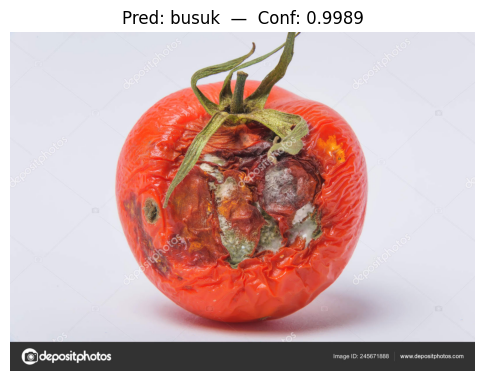


Final prediction: busuk (confidence 0.9989)


In [ ]:
# SINGLE CELL: load model, inspect, predict one image, fallback logits->softmax, show image + probs
import os, sys
from ultralytics import YOLO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ---- CONFIG: ganti jika perlu ----
BEST_PT   = "/content/drive/MyDrive/tomat_cls/runs_classify/rf_tomat_exp12/weights/best.pt" # Updated BEST_PT to match latest run
IMG_PATH  = "/content/drive/MyDrive/tomat_cls/my_tests/depositphotos_245671888-stock-photo-rotten-tomato-mold-vegetables-rotten.jpg"   # ganti ke gambarmu
IMGSZ     = 224
RUN_VAL_ON_DATASET = False   # True untuk menjalankan model.val(data=DATA_DIR) (opsional)
DATA_DIR  = "/content/drive/MyDrive/tomat_cls/tomat_anj-1"  # dataset dir (train/val) jika mau val

# ---- sanity checks ----
print("BEST_PT exists:", os.path.isfile(BEST_PT))
if os.path.isfile(BEST_PT):
    print("BEST_PT size (MB):", os.path.getsize(BEST_PT)/1024/1024)
else:
    raise FileNotFoundError(f"best.pt not found: {BEST_PT}")

print("IMG_PATH exists:", os.path.isfile(IMG_PATH))
if not os.path.isfile(IMG_PATH):
    raise FileNotFoundError(f"Image not found: {IMG_PATH}")

# ---- load model ----
model = YOLO(BEST_PT)
print("Loaded model. model.names:", getattr(model, "names", None))

# optional: run validation on dataset (uncomment if wanted)
if RUN_VAL_ON_DATASET:
    try:
        print("\nRunning model.val(...) on DATA_DIR (may take time)...")
        print("DATA_DIR exists:", os.path.isdir(DATA_DIR))
        val_metrics = model.val(data=DATA_DIR)
        print("Validation metrics:", val_metrics)
    except Exception as e:
        print("model.val failed:", e)

# ---- predict single image & robustly get probabilities ----
print("\nPredicting image:", IMG_PATH)
res_list = model.predict(source=IMG_PATH, imgsz=IMGSZ, verbose=False)  # returns list
if len(res_list) == 0:
    raise RuntimeError("No result returned from model.predict()")

res = res_list[0]

# Try to extract probs
probs = None
if hasattr(res, "probs") and res.probs is not None:
    try:
        # Corrected extraction: access .data, move to CPU, convert to numpy, then ravel
        probs = res.probs.data.cpu().numpy().ravel()
    except Exception as e:
        print(f"[ERROR] Error extracting probs from res.probs: {e}")
        probs = None

# If probs missing, try logits -> softmax
if probs is None:
    if hasattr(res, "logits") and res.logits is not None:
        try:
            logits = res.logits.cpu().numpy().ravel()
        except Exception:
            logits = res.logits.numpy().ravel()
        ex = np.exp(logits - np.max(logits))
        probs = ex / np.sum(ex)
        print("[INFO] probs computed from logits via softmax.")
    else:
        # final fallback: get names from model and create zeros
        names_from_model = getattr(model, "names", None)
        n = len(names_from_model) if names_from_model is not None else 2
        probs = np.zeros(n)
        print("[WARN] No probs or logits in result; producing zero-probabilities fallback.")

# names (class labels)
names = getattr(model, "names", None)
# Ensure names is a list, converting from dict if necessary
if isinstance(names, dict):
    names = [names[i] for i in sorted(names.keys())]
elif names is None:
    names = [f"class{i}" for i in range(len(probs))]

print("\nClass names:", names)
print("Probs array:", probs, "sum:", float(np.sum(probs)))

# print ranked probabilities
rank_idx = np.argsort(-probs)
print("\nPredictions (ranked):")
for i in rank_idx:
    print(f" {i:02d}. {names[i]:<20} {probs[i]:.6f}")

pred_idx = int(np.argmax(probs))
pred_name = names[pred_idx]
confidence = float(probs[pred_idx])

# display image with title
img = Image.open(IMG_PATH).convert("RGB")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title(f"Pred: {pred_name}  —  Conf: {confidence:.4f}")
plt.show()

# final quick check: if all probs are zero (fallback), warn user
if np.allclose(probs, 0.0):
    print("\n!!! WARNING: All probabilities are zero. This means the result object had no probs/logits.")
    print("Possible causes:")
    print("- The loaded model is not a classification model (maybe detection weights).")
    print("- best.pt is corrupted or not the expected classifier checkpoint.")
    print("- ultralytics version incompatibility changed result attributes.")
    print("\nRecommended next steps:")
    print("- Verify you trained with a classifier model (yolov8n-cls.pt) and `task=classify`.")
    print("- Re-open training logs to ensure training completed and produced a proper best.pt.")
    print("- If 'res.logits' existed above, we computed softmax; else retrain or load correct checkpoint.")
else:
    print(f"\nFinal prediction: {pred_name} (confidence {confidence:.4f})")